[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module4_Files/a_Many_To_Many_BDL_tmpf_and_vsby.ipynb)

# a_Many To Many (Numeric Sequences)
------------------------------------
**Dr. Dave Wanik - University of Connecticut**

[y is two different variables, at (one) the same timestep]

Let's read in the BDL data and see if we can *predict two quantities at once*! Dewpoint (dwpf) and Mean Sea-level Pressure (mslp).

In [ ]:
# import modules
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
#from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
#from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
# # https://drive.google.com/file/d/1vhWT7__EDc-WQ7WGnK0RP2qq7-25LCWS/view?usp=sharing
# !gdown 1vhWT7__EDc-WQ7WGnK0RP2qq7-25LCWS
# # read the data
# df = pd.read_csv('cleanBDL.csv')

Downloading...
From: https://drive.google.com/uc?id=1vhWT7__EDc-WQ7WGnK0RP2qq7-25LCWS
To: /content/cleanBDL.csv
100% 4.40M/4.40M [00:00<00:00, 67.1MB/s]


In [ ]:
# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module4_Files/cleanBDL.csv"

# retrieve the CSV data and build a dataframe
df = pd.read_csv(url)

df.shape

(46272, 10)

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46272 entries, 0 to 46271
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   valid   46272 non-null  object 
 1   tmpf    46272 non-null  float64
 2   dwpf    46272 non-null  float64
 3   relh    46272 non-null  float64
 4   drct    46272 non-null  float64
 5   sknt    46272 non-null  float64
 6   p01i    46272 non-null  float64
 7   alti    46272 non-null  float64
 8   mslp    46272 non-null  float64
 9   vsby    46272 non-null  float64
dtypes: float64(9), object(1)
memory usage: 3.5+ MB


,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby
0,2015-01-01 00:00:00,17.96,6.08,59.10,190.0,5.0,0.0,30.09,1019.0,10.0
1,2015-01-01 01:00:00,19.94,8.06,59.40,190.0,5.0,0.0,30.08,1018.7,10.0
2,2015-01-01 02:00:00,23.00,6.98,49.69,210.0,9.0,0.0,30.06,1018.1,10.0
3,2015-01-01 03:00:00,21.92,5.00,47.52,230.0,11.0,0.0,30.04,1017.4,10.0
4,2015-01-01 04:00:00,23.00,3.92,43.21,250.0,13.0,0.0,30.05,1017.7,10.0


# Define X and Y
If we are going to use our split sequences script from Brownlee, then we need to make sure our Y variables are on the end!

In [ ]:
# let's drop the valid column
# Y will be dwpf and relh
# X will be everything else!

del df['valid']
df.head() # check your work

,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby
0,17.96,6.08,59.10,190.0,5.0,0.0,30.09,1019.0,10.0
1,19.94,8.06,59.40,190.0,5.0,0.0,30.08,1018.7,10.0
2,23.00,6.98,49.69,210.0,9.0,0.0,30.06,1018.1,10.0
3,21.92,5.00,47.52,230.0,11.0,0.0,30.04,1017.4,10.0
4,23.00,3.92,43.21,250.0,13.0,0.0,30.05,1017.7,10.0


In [ ]:
Y = df[['dwpf', 'mslp']]
X = df.drop(axis=1, columns=['dwpf', 'mslp'])
print(df.shape, X.shape, Y.shape)

# looks good! Let's prepare samples for modeling

(46272, 9) (46272, 7) (46272, 2)


In [ ]:
# put Y all the way on the left
df = pd.concat([X, Y], axis=1, sort=False)
df.head(n=11)

,tmpf,relh,drct,sknt,p01i,alti,vsby,dwpf,mslp
0,17.96,59.10,190.0,5.0,0.0,30.09,10.0,6.08,1019.0
1,19.94,59.40,190.0,5.0,0.0,30.08,10.0,8.06,1018.7
2,23.00,49.69,210.0,9.0,0.0,30.06,10.0,6.98,1018.1
3,21.92,47.52,230.0,11.0,0.0,30.04,10.0,5.00,1017.4
4,23.00,43.21,250.0,13.0,0.0,30.05,10.0,3.92,1017.7
5,23.00,43.21,250.0,11.0,0.0,30.06,10.0,3.92,1018.1
6,23.00,41.45,240.0,13.0,0.0,30.07,10.0,3.02,1018.4
7,24.08,41.30,240.0,11.0,0.0,30.08,10.0,3.92,1018.9
8,26.06,38.03,210.0,8.0,0.0,30.08,10.0,3.92,1018.9
9,28.04,35.05,220.0,14.0,0.0,30.08,10.0,3.92,1018.8


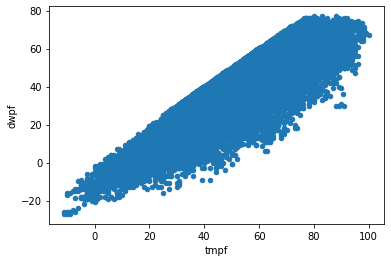

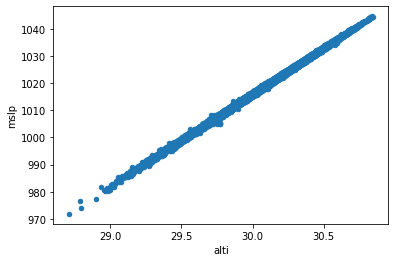

In [ ]:
# some eda
df.plot.scatter(x='tmpf', y='dwpf')
df.plot.scatter(x='alti', y='mslp')

In [ ]:
# to get our other code to run, we will put Y
# on the end then re-run our code (needs updating from blog)

# prep data for modeling (multivariate)
# link: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
    # X and Y have been UPDATED so the last two columns drop off
		# USERS NEED TO UPDATE THIS FOR THEIR OWN PROBLEMS!!!
		seq_x, seq_y = sequences[i:end_ix, :-2], sequences[end_ix-1, 7:]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# Prepare Samples for Modeling
Everything needs to be in 3D arrays.

In [ ]:
# let's turn X into lookbacks of 10 with all of our samples
# all we need to do is decide on is n_steps (what our lookback period is)
# since we have a bunch of data, why not n_steps=10? then try 30 later on.
n_steps = 10
raw_seq = np.array(df) #make sure your data is stored as a numpy array!
# let's ignore the date column and just use the temperature data
X, y = split_sequences(raw_seq, n_steps=10)

In [ ]:
# check your work
print(df.shape, X.shape, y.shape)

(46272, 9) (46263, 10, 7) (46263, 2)


In [ ]:
# here's the first X
X[0]

array([[ 17.96,  59.1 , 190.  ,   5.  ,   0.  ,  30.09,  10.  ],
       [ 19.94,  59.4 , 190.  ,   5.  ,   0.  ,  30.08,  10.  ],
       [ 23.  ,  49.69, 210.  ,   9.  ,   0.  ,  30.06,  10.  ],
       [ 21.92,  47.52, 230.  ,  11.  ,   0.  ,  30.04,  10.  ],
       [ 23.  ,  43.21, 250.  ,  13.  ,   0.  ,  30.05,  10.  ],
       [ 23.  ,  43.21, 250.  ,  11.  ,   0.  ,  30.06,  10.  ],
       [ 23.  ,  41.45, 240.  ,  13.  ,   0.  ,  30.07,  10.  ],
       [ 24.08,  41.3 , 240.  ,  11.  ,   0.  ,  30.08,  10.  ],
       [ 26.06,  38.03, 210.  ,   8.  ,   0.  ,  30.08,  10.  ],
       [ 28.04,  35.05, 220.  ,  14.  ,   0.  ,  30.08,  10.  ]])

In [ ]:
# here's the first Y
y[0]

# go scroll up and make sure this matches!
# and it does!

# you will need to customize your split script when
# prepping your data... be careful! take control of your data!

array([   3.92, 1018.8 ])

In [ ]:
df.head(n=15)

,tmpf,relh,drct,sknt,p01i,alti,vsby,dwpf,mslp
0,17.96,59.10,190.0,5.0,0.0,30.09,10.0,6.08,1019.0
1,19.94,59.40,190.0,5.0,0.0,30.08,10.0,8.06,1018.7
2,23.00,49.69,210.0,9.0,0.0,30.06,10.0,6.98,1018.1
3,21.92,47.52,230.0,11.0,0.0,30.04,10.0,5.00,1017.4
4,23.00,43.21,250.0,13.0,0.0,30.05,10.0,3.92,1017.7
5,23.00,43.21,250.0,11.0,0.0,30.06,10.0,3.92,1018.1
6,23.00,41.45,240.0,13.0,0.0,30.07,10.0,3.02,1018.4
7,24.08,41.30,240.0,11.0,0.0,30.08,10.0,3.92,1018.9
8,26.06,38.03,210.0,8.0,0.0,30.08,10.0,3.92,1018.9
9,28.04,35.05,220.0,14.0,0.0,30.08,10.0,3.92,1018.8


# Fit a Model
This will be similar to the last example in 'Sequence Problems_Pt1.ipynb'

In [ ]:
# note how there's a 2 at the end
# usually we did this for a multi-classification problem, but not today!
# by default, it's a 'linear' activiation function
# so this is 2 node output and we're doing regression.

n_steps = X.shape[1]
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu',
               recurrent_dropout = 0.1,
               input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(2)) # since Y has two values, we need to predict two values
model.compile(optimizer='adam', loss='mse')

import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in
# the validation loss for 10 consecutive epochs.
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=10, # you can play with this!
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X,
                    y,
                    callbacks=[es],
                    epochs=800, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/800
3701/3701 [==============================] - 39s 10ms/step - loss: 19479.1992 - val_loss: 4197.8794
Epoch 2/800
3701/3701 [==============================] - 39s 10ms/step - loss: 7631.1597 - val_loss: 310.6028
Epoch 3/800
3701/3701 [==============================] - 42s 11ms/step - loss: 7279.7510 - val_loss: 495.4328
Epoch 4/800
3701/3701 [==============================] - 36s 10ms/step - loss: 7066.7051 - val_loss: 1348.7335
Epoch 5/800
3701/3701 [==============================] - 36s 10ms/step - loss: 6942.7192 - val_loss: 820.7538
Epoch 6/800
3701/3701 [==============================] - 36s 10ms/step - loss: 6905.9194 - val_loss: 2463.5769
Epoch 7/800
3701/3701 [==============================] - 37s 10ms/step - loss: 6727.7456 - val_loss: 220.6017
Epoch 8/800
3701/3701 [==============================] - 34s 9ms/step - loss: 6745.4302 - val_loss: 2268.9434
Epoch 9/800
3701/3701 [==============================] - 34s 9ms/step - loss: 6588.1372 - val_loss: 1489.9812
Epoch 

In [ ]:
# and you can show how your model did

# since it's a single sample, we need to reshape
data = X[0]
data = data.reshape(1,10,7)
print(data)
print(model.predict(data))

# did we get close?
print(y[0])
# of course you can show scatterplots and everything else

[[[ 17.96  59.1  190.     5.     0.    30.09  10.  ]
  [ 19.94  59.4  190.     5.     0.    30.08  10.  ]
  [ 23.    49.69 210.     9.     0.    30.06  10.  ]
  [ 21.92  47.52 230.    11.     0.    30.04  10.  ]
  [ 23.    43.21 250.    13.     0.    30.05  10.  ]
  [ 23.    43.21 250.    11.     0.    30.06  10.  ]
  [ 23.    41.45 240.    13.     0.    30.07  10.  ]
  [ 24.08  41.3  240.    11.     0.    30.08  10.  ]
  [ 26.06  38.03 210.     8.     0.    30.08  10.  ]
  [ 28.04  35.05 220.    14.     0.    30.08  10.  ]]]
1/1 [==============================] - 0s 310ms/step
[[  26.881792 1015.07874 ]]
[   3.92 1018.8 ]


In [ ]:
# well done! You can also make scatterplots of actual vs. predicted
pred = model.predict(X)
pred

1446/1446 [==============================] - 5s 3ms/step


array([[  26.88179 , 1015.0787  ],
       [  27.071068, 1015.8112  ],
       [  27.471872, 1018.0251  ],
       ...,
       [  35.16939 , 1008.7328  ],
       [  34.990215, 1007.3141  ],
       [  35.40531 , 1009.2861  ]], dtype=float32)

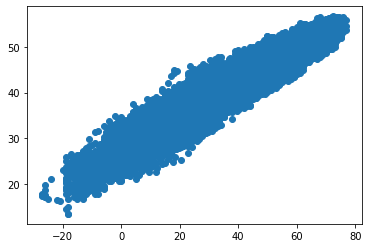

In [ ]:
# pred1
plt.scatter(y[:,0], pred[:,0])
plt.show()

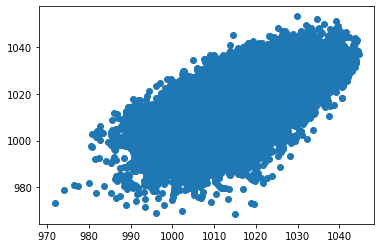

In [ ]:
# pred2
plt.scatter(y[:,1], pred[:,1])
plt.show()

In [ ]:
# it worked! predict two outputs at once -
# may have taken longer to fit,
# but it worked great!

# you may also try other architectures
# and advanced methods (Conv1D and MaxPooling1D etc)